In [1]:
import numpy as np 
import pandas as pd
import allel
import bokeh
import bokeh.plotting
import malariagen_data
%matplotlib inline
import sys
# adding Folder_2 to the system path
sys.path.insert(0, '/home/sanj/projects/gaardian/workflow/scripts/')
import probetools as probe
%run hapclust.py
bokeh.io.reset_output()

In [2]:
def plot_snps(transcript, data, cohorts, width=1500, height=600, palette='Category10', sample_set="sample_set"):

    # hover tooltips
    tooltips = [
        ("position", '@contig:@position{,}'),
        ("alleles", '@ref_allele>@alt_allele'),
        ("pass", "@pass_gamb_colu_arab, @pass_gamb_colu, @pass_arab"),
        ("impact", '@impact'),
        ("effect", '@effect'),
        ("aa_change", '@aa_change'),
        ("frequency", '@frequency{%f} (@cohort)'),
        ("freqdiff from wildtype", '@freq_diff_from_wt{%f}'),
    ]

    fig1 = bokeh.plotting.figure(
        title=f'Transcript - {transcript}',
        tools='xpan,xzoom_in,xzoom_out,xwheel_zoom,reset,hover',
        active_scroll='xwheel_zoom',
        active_drag='xpan',
        plot_width=width, 
        plot_height=height, 
        tooltips=tooltips,
        toolbar_location="above")

    # set up colors
    palette = bokeh.palettes.all_palettes[palette]
    colors = palette[len(cohorts)] if len(cohorts) > 2 else palette[3]
    
    # plot allele frequencies
    for coh, color in zip(cohorts, colors):
        df = data.copy()
        # add X coordinate in Mbp
        df['x'] = df['position'] / 1e6
        df['frequency'] = df[coh]
        df['cohort'] = coh
        df['freq_diff_from_wt'] = data[f"{coh} | freqdiff"] if "wt" not in coh else 0 
        diffdf = df.query("freq_diff_from_wt > 0.4")
        df = df.query("freq_diff_from_wt < 0.4")
        fig1.triangle("x", coh, 
                      size=8, 
                      color=color,
                      source=df,
                      legend_label=coh)
        fig1.circle("x", coh, 
                    size=10, color=color, 
                    source=diffdf,
                    legend_label=coh)

    # tidy up the plot
    fig1.y_range = bokeh.models.Range1d(-0.05, 1.1)
    fig1.yaxis.axis_label = f'Alt allele frequency'
    fig1.xaxis.visible = False
    fig1.add_layout(fig1.legend[0], 'right')
    fig1.legend.click_policy="hide"

    # plot transcript
    fig2 = plot_transcript(transcript, width=width, height=80, show=False, 
                           x_range=fig1.x_range)
    fig2.toolbar.logo = None 
    fig2.toolbar_location = None
    fig2.title = None #sample_set

    bokeh.plotting.show(bokeh.layouts.column(fig1, fig2))
    
def plot_transcript(transcript, width=700, height=120, show=True, x_range=None,
                    toolbar_location='above'):

    # find the gene
    df_geneset = ag3.geneset().set_index("ID")
    parent  = df_geneset.loc[transcript]

    # define tooltips for hover
    tooltips = [
        ("Type", '@type'),
        ("Location", '@contig:@start{,}..@end{,}'),
    ]

    # make a figure
    fig = bokeh.plotting.figure(
        title=f'Transcript - {transcript} ({parent.strand})',
        plot_width=width, 
        plot_height=height,
        tools='xpan,xzoom_in,xzoom_out,xwheel_zoom,reset,hover',
        toolbar_location=toolbar_location,
        active_scroll='xwheel_zoom',
        active_drag='xpan',
        tooltips=tooltips,
        x_range=x_range,
    )

    # find child components of the transcript
    data = df_geneset.query(f"Parent == '{transcript}'").copy()
    data['left'] = data['start'] / 1e6  # plot in Mbp coordinates
    data['right'] = data['end'] / 1e6  # plot in Mbp coordinates
    data['bottom'] = -0.4
    data['top'] = 0.4

    # plot exons
    exons = data.query("type == 'exon'")
    fig.quad(bottom='bottom', top='top', left='left', right='right',
             source=exons, fill_color=None, line_color='black', line_width=.5, 
             fill_alpha=0)
    
    # plot introns
    for l, r in zip(exons[:-1]['right'], exons[1:]['left']):
        m = (l + r) / 2
        fig.line([l, m, r], [0, .1, 0], line_width=1, line_color="black")

    # plot UTRs
    fig.quad(bottom='bottom', top='top', left='left', right='right',
                source=data.query("type == 'five_prime_UTR'"), 
                fill_color='green', line_width=0, fill_alpha=.5)
    fig.quad(bottom='bottom', top='top', left='left', right='right',
                source=data.query("type == 'three_prime_UTR'"), 
                fill_color='red', line_width=0, fill_alpha=.5)

    # plot CDSs
    fig.quad(bottom='bottom', top='top', left='left', right='right',
             source=data.query("type == 'CDS'"), 
             fill_color='blue', line_width=0, fill_alpha=.5)

    fig.yaxis.ticker = []
    fig.xaxis.axis_label = f'Position (Mbp)'
    fig.y_range = bokeh.models.Range1d(-.6, .6)

    fig.xaxis.axis_label = f'Contig {parent.contig} position (Mbp)'

    # show the figure
    if show:
        bokeh.plotting.show(fig)

    return fig

In [14]:
def clustersToFrequencies(transcript, cluster_spans, geno, pos, SNPeffect='NON_SYNONYMOUS_CODING', max_af=0.02, min_cohort_size=5, sample_set="sample_set"):
    
    # get totals in each sweep for swept and wt, store in dict
    cohorts = {f"Sweep n={c[2].shape[0]}":c[2] for idx, c in enumerate(cluster_spans) if c[2].shape[0] > min_cohort_size}
    wt = {f"wt_{idx}":c[2] for idx, c in enumerate(cluster_spans) if c[2].shape[0] < min_cohort_size}
    lenwt = len(np.concatenate(list(wt.values())))
    cohorts[f'wt n={lenwt}'] = np.concatenate(list(wt.values()))
    
    probe.log(f"There are {len(cohorts.keys())} clusters with {[len(c) for c in cohorts.values()]}")
    
    #calculate allele freqs in cohort 
    df_snps = get_afs_from_cohort(cohorts, geno, pos, transcript, min_cohort_size)
    # filter to snp eff and max af
    df_snps_filtered = df_snps.query("effect == @SNPeffect and max_af > @max_af")
    
    #change cohort dict keys to amino acid signature (what is diff from wt?)
    newcohort, df_snps_filtered = get_aasig_for_swept_cohorts(cohorts, df_snps_filtered)
    
    #plot allele frequencies for each cohort 
    #plot_snps(transcript, data=df_snps_filtered, cohorts=newcohort, sample_set=sample_set)
    
    return(df_snps_filtered, newcohort)

def TranscriptSweptAlleleFreqs(snps, pos, transcript, cut_height = 120, t=2, min_cohort_size=5, sample_set="sample_set", dendro_only=False, metaquery=None):
    
    probe.log("Remapping haplotype alleles to match snp effect data...")   
    haplos = allel.GenotypeArray(snps['call_genotype']).to_haplotypes()
    haplos, pos = remap_haplo_alleles(haplos, pos, metaquery, sample_set)
        
    probe.log("Clustering genotypes")
    fig, ax_dend, ax_freq, cluster_spans, leaves = fig_haplotypes_clustered(haplos, 
                                                              truncate_distance=t,
                                                              cut_height=cut_height,
                                                              dpi=150, label_clusters=False)
    
    probe.log("Finding allele frequencies from cluster indices")
    # Take clusters and get freqs in each cluster
    df_snps_filtered, newcohort = clustersToFrequencies(transcript, cluster_spans, geno=haplos, pos=pos, min_cohort_size=min_cohort_size, sample_set=sample_set)

    return(df_snps_filtered, newcohort, leaves)
    
    
def phase3cluster(sample_set, transcript, contig, metaquery=None, cut=2, t=2, min_cohort_size=5):
    snps = ag3.haplotypes(transcript, sample_sets=sample_set, analysis='gamb_colu')
    meta = ag3.sample_metadata(sample_set)

    if metaquery != None:
        meta = ag3.sample_metadata(cohorts)
        meta = meta.query(metaquery)
        sample_bool = np.isin(snps['sample_id'].compute(), meta['sample_id'])
        snps = snps.isel(samples=sample_bool)

    probe.log(f"{sample_set}, query={metaquery}, cohort_size : {snps['call_genotype'].shape[1]}, nSNPs: {snps['call_genotype'].shape[0]}")

    df_af, coh, leaves = TranscriptSweptAlleleFreqs(snps, allel.SortedIndex(snps['variant_position']), transcript, cut_height=cut, t=t, min_cohort_size=min_cohort_size, sample_set=sample_set, metaquery=metaquery)  
    return(df_af, coh, leaves)

In [15]:
def get_afs_from_cohort(cohorts, geno, pos, transcript, min_cohort_size):
    freq_cols = dict()
    for coh, loc_coh in cohorts.items():
        n_samples = np.count_nonzero(loc_coh)
        if n_samples == 0:
            raise ValueError(f"no samples for cohort {coh!r}")
        if n_samples >= min_cohort_size:
            gt_coh = geno.take(loc_coh, axis=1)
            # count alleles
            ac_coh = gt_coh.count_alleles(max_allele=3)
            # compute allele frequencies
            af_coh = ac_coh.to_frequencies()
            # add column to dict
            freq_cols[coh] = af_coh[:, 1:].flatten()

    # build a dataframe with the frequency columns
    df_freqs = pd.DataFrame(freq_cols)

    # compute effects for all SNPs in chosen transcript
    df_effects = ag3.snp_effects(
        transcript=transcript, 
    )
    
    pos_bool = np.isin(df_effects['position'], pos)
    df_effects = df_effects[pos_bool]
    
    # build the final dataframe
    df_effects.reset_index(drop=True, inplace=True)
    df_snps = pd.concat([df_effects, df_freqs], axis=1)

    # add max allele freq column (concat here also reduces fragmentation)
    df_snps = pd.concat(
        [
            df_snps,
            pd.DataFrame(
                {"max_af": df_snps[list(freq_cols.keys())].max(axis=1)}
            ),
        ],
        axis=1,
    )
    return(df_snps)


def get_aasig_for_swept_cohorts(cohorts, df_snps_filtered):
    newcohort = {}
    for key, idxs in cohorts.items():
        # copy df
        df = df_snps_filtered.copy()
        # calculate AF diff between wt and each sweep
        df['af_diff']= df[key] - df.filter(regex="wt").iloc[:,0]
        # difference has to be greater than 0.4 (arbitrary)
        aadiff = df[df['af_diff'] > 0.4]['aa_change'] #.abs() used if we want aa reversion to show on signature
        # remove first digits
        aa = aadiff.str.slice(1)
        aa = ",".join(aadiff)
        n = int(''.join(filter(str.isdigit, key)))
        aa = f"n={n} | {aa}"
        if "wt" not in key:
            newcohort[aa] = idxs
            df_snps_filtered = df_snps_filtered.rename(columns={key:aa})
            df_snps_filtered[f"{aa} | freqdiff"] = (df_snps_filtered.filter(regex="wt").iloc[:,0] - df_snps_filtered[aa]).abs()
        else:
            newcohort[key] = idxs
        
    return(newcohort, df_snps_filtered)

def remap_haplo_alleles(haplos, haplo_pos, metaquery, cohorts):
    """
    Because haplotypes are coded 0,1, but genotypes 0-3, 1s in the haplotype may refer to different ALTs in the genotype array. This
    causes a problem when using ag3.snp_effects() to fit alleles to their aa change, therefore, we need to recode alleles back to the correct
    ALT
    """
    # Load genotype data - needed to find correct ALT for each SNP
    geno = allel.GenotypeDaskArray(ag3.snp_genotypes(region=transcript, sample_sets=cohorts))
    meta = ag3.sample_metadata(cohorts)
    if metaquery != None:
        meta = meta.query(metaquery)
    geno = geno.take(meta.index.to_list(), axis=1)
    geno_pos = allel.SortedIndex(ag3.snp_sites(region=transcript, field='POS').compute())
    
    # find intersection between haplotype positions and genotypes 
    geno_mask, hap_mask = geno_pos.locate_intersection(haplo_pos)
    geno = geno.compress(geno_mask, axis=0)
    ac = geno.count_alleles().compute()
    
    # remove multiallelics, there shouldnt be any in here?
    multiallele_mask = (ac > 0).sum(axis=1) > 2
    ac = ac[~multiallele_mask]
    # find appropriate allele
    mappings = np.argmax(ac[:,1:], axis=1) + 1
    # make mapping array for scikit-allel
    zeros = np.zeros(len(mappings))
    mapping = np.vstack([zeros, mappings]).T
    
    # Remap!
    haplos = haplos[~multiallele_mask].map_alleles(mapping)
    haplo_pos  = haplo_pos[~multiallele_mask]
       
    return(haplos, haplo_pos)

In [67]:
def haploSelectionPlot(cohorts, contig, transcript, cut=1, metaquery=None, min_cohort_size=40, reverse=False, karyo=False):
    gene_start, gene_end = allel.gff3_to_dataframe("../../../IR/rna-seq-busia/resources/reference/Anopheles-gambiae-PEST_BASEFEATURES_AgamP4.12.gff3",
                                    attributes=['ID']).query("ID == @gene")[['start', 'end']].to_numpy()[0]
    
    snpdf, coho, leaves = phase3cluster(cohorts, transcript, contig, cut=cut, t=0, min_cohort_size=min_cohort_size, metaquery=metaquery)
    leaf_order = flatten_list(leaves)
    
    snps = ag3.haplotypes(contig, sample_sets=cohorts, analysis='gamb_colu')
    names = snps['sample_id'].values
    metahaps, bool_ = load_metahaps(cohorts, names, metaquery=metaquery)

    if metaquery != None: 
        snps = snps.isel(samples=bool_)

    assert metahaps.shape[0] == snps['call_genotype'].shape[1]*2, "Wrong shape Dude!!"
    assert len(leaf_order) == metahaps.shape[0], "Wrong shape!!"
    
#    id_order = metahaps['sample_id'].to_list()
 #   id_order_clustered = metahaps.iloc[leaf_order, :]['sample_id'].to_list()
 #   check_order(metahaps, id_order)
    
    #Subset the data to all aa changes above 5% frequency
    myquery = "max_af > 0.05 & effect == 'NON_SYNONYMOUS_CODING'"
    aa_snps = snpdf.query(myquery)['position'].to_list()
    pos_bool = allel.SortedIndex(snps['variant_position']).locate_intersection(aa_snps)[0]
    print(f"There are {len(aa_snps)} amino acid changes with {myquery}")

    haps_df = pd.DataFrame(allel.GenotypeArray(snps['call_genotype'].isel(variants=pos_bool).compute()).to_haplotypes())
    haps_df['aa_change'] = snpdf.query(myquery).reset_index()['aa_change']
    haps_df = haps_df.set_index('aa_change')
    if reverse == True: haps_df = haps_df.iloc[::-1] # only if reverse strand like AGAP006227
    haps_df = haps_df.iloc[:, leaf_order] # can only run once!
    
    pop_column = 'country'
    pop_order = metahaps.iloc[leaf_order, :][pop_column].to_frame()
    colours = probe.get_colour_dict(pop_order[pop_column])

    if karyo == True:
        probe.log("Integrating karyotype data...")
        karyo = pd.read_csv("/home/sanj/projects/gaardian/results/gaard_and_ag3.2la.karyo.tsv", sep="\t", index_col=0)
        karyo = karyo.rename(columns={'partner_sample_id': 'sample_id'})
        g = karyo.groupby('sample_id')
        karyo['sample_id'] += g.cumcount().astype(str).replace("0", "").mask(g['sample_id'].transform('count')==1,'')
        g = metahaps.groupby('sample_id')
        metahaps['sample_id'] += g.cumcount().astype(str).replace("0", "").mask(g['sample_id'].transform('count')==1,'')
        metahaps = metahaps.merge(karyo)

    probe.log("Integrating CNV data...")
    cnv_data = ag3.gene_cnv(region=myregion, sample_sets=cohorts)
    cnv_data = cnv_data.to_dataframe().query("gene_id == @gene")
    cnv_data = cnv_data.query("CN_mode > 2.9")
    dup_names = cnv_data['sample_id'].to_list()

    metahaps = metahaps.iloc[leaf_order, :] # make order of metadata same as clustering leaves
    metahaps['cnv_status'] = np.isin(metahaps['sample_id'], dup_names).astype(int)
    cnv_data = metahaps.loc[:,'cnv_status'].to_frame()
    # species row 
    sp_df = metahaps.loc[:,'aim_species'].to_frame()
    sp_colours =probe.get_colour_dict(sp_df['aim_species'].unique())
    
    if karyo == True:
        karyo = metahaps.loc[:, 'mean_genotype'].to_frame()
        karyo['mean_genotype'] = karyo['mean_genotype'].round(0)   
    
    gene_bool = allel.SortedIndex(snps['variant_position']).locate_ranges([gene_start], [gene_end])
    haps = allel.GenotypeArray(snps['call_genotype'].isel(variants=gene_bool).compute()).to_haplotypes()
    
    mylen = np.vectorize(len)
    bool_ = mylen(leaves) > min_cohort_size
    clusters = np.array(leaves)[bool_]
    clusters = [np.array([c[0], c[-1]]) for c in clusters]
    cluster_start_stop = [np.array([np.where(leaf_order == c[0])[0][0], np.where(leaf_order == c[1])[0][0]]) for c in clusters]
    
    # Get Legend rectangles for cohorts
    bars = {}
    for k,v in colours.items():
        bars[k] = plt.Rectangle((0,0),1,1,fc=v, edgecolor = 'none')
    

    if karyo == True:
        fig, ax = plt.subplots(6,1, figsize=[20,10], gridspec_kw={'height_ratios': [8, 1, 1, 1, 1, 12]})
        aaplot_i = 5
    else:
        fig, ax = plt.subplots(5,1, figsize=[20,10], gridspec_kw={'height_ratios': [8, 1, 1, 1, 12]})
        aaplot_i = 4

    fig, ax_dend, ax_freq, cluster_spans, leaf2 = fig_haplotypes_clustered_dendro(haps, 
                                                          truncate_distance=0,
                                                          cut_height=2,
                                                          dpi=150, label_clusters=False, ax_dend=ax[0])

    ax[0].set_ylabel("Distance (no. SNPs)", fontsize=13)
    ax[0].set_xlabel("Haplotypes", fontsize=13)
    ax[0].xaxis.tick_top()
    ax[0].xaxis.set_label_position('top')
    #ax[0].set_xticks(np.arange(0, len(pop_order), 200))

    for i, pop in enumerate(pop_order[pop_column]):
        ax[1].axvline(x=i, color=colours[pop])
    sns.despine(ax=ax[1], left=True, bottom=True)
    ax[1].set_xlim(0, len(pop_order))

    for i, sp in enumerate(sp_df['aim_species']):
        ax[2].axvline(x=i, color=sp_colours[sp])
    sns.despine(ax=ax[2], left=True, bottom=True)
    ax[2].set_xlim(0, len(sp_df))

    for axes in ax[1:]:
        axes.tick_params(
            axis='x',          # changes apply to the x-axis
            which='both',      # both major and minor ticks are affected
            bottom=False,      # ticks along the bottom edge are off
            top=False,         # ticks along the top edge are off
            labelbottom=False)


    sns.heatmap(ax=ax[3], data=cnv_data.T, cmap='Greys', xticklabels="", cbar=None, alpha=0.9)
    sns.heatmap(ax=ax[aaplot_i], data=haps_df, cmap='Greys', cbar=None, xticklabels="")

    if karyo == True: 
        sns.heatmap(ax=ax[4], data=karyo.T, cmap='Greys', xticklabels="", cbar=None, alpha=0.9)
        ax[4].tick_params(axis='y', which='both', left=False)
        ax[4].set_ylabel('2La', rotation = 0, fontsize=13, loc='center', labelpad=20)
        ax[4].set_yticklabels("")
    
    
    ax[1].tick_params(axis='y', which='both', left=False)
    ax[2].tick_params(axis='y', which='both', left=False)
    ax[3].tick_params(axis='y', which='both', left=False)

    ax[1].set_ylabel('Country', rotation = 0, fontsize=13, loc='center', labelpad=25)
    ax[1].set_yticklabels("")
    ax[2].set_ylabel('Species', rotation = 0, fontsize=13, loc='center', labelpad=20)
    ax[2].set_yticklabels("")
    ax[3].set_ylabel('CNV', rotation = 0, fontsize=13, loc='center', labelpad=20)
    ax[3].set_yticklabels("")
    ax[aaplot_i].set_ylabel('Non-synonymous SNPs', fontsize=13, loc='center')


    for start, stop in cluster_start_stop:
        ax[aaplot_i].axvline(start, color='grey', linestyle="dotted")
        ax[aaplot_i].axvline(stop, color='grey', linestyle="dotted")
        ax[aaplot_i].add_patch(plt.Rectangle(xy=(start, 0),
                                           width=stop-start,
                                                height=40,
                                              color="blue", alpha=0.05))

    for i in range(haps_df.shape[0] + 1):
        ax[aaplot_i].axhline(i, color='grey', lw=2)

    for _, spine in ax[aaplot_i].spines.items():
        spine.set_visible(True)

    l = ax[0].legend(bars.values(), bars.keys(), loc='best', ncol=2, fancybox=True, shadow=True, framealpha=0.95, prop={'size':16})
    l.draw_frame(True)

In [68]:
def flatten_list(_2d_list):
    flat_list = []
    # Iterate through the outer list
    for element in _2d_list:
        if type(element) is list:
            # If the element is of type list, iterate through the sublist
            for item in element:
                flat_list.append(item)
        else:
            flat_list.append(element)
    return flat_list

def load_metahaps(cohorts, names, metaquery = "aim_species == 'gambiae'"):
    meta = ag3.sample_metadata(cohorts)
    meta = meta.query("sample_id in @names")
    meta['sample_id'] = pd.Categorical(meta['sample_id'], categories = names, ordered = True)
    meta = meta.sort_values(by='sample_id')
    metahaps = pd.DataFrame(np.repeat(meta.values, 2, axis=0))
    metahaps.columns = meta.columns
    
    if metaquery != None: 
        bool_ = metahaps.eval(metaquery).to_numpy()
        meta = meta.query(metaquery)
    else:
        bool_ = []
        
    return(metahaps, bool_)

def check_order(meta, order, col='sample_id'):
    assert meta[col].to_list() == order, "Order of metadata is incorrect"
    print("correct order")

## COE sweeps analysis

In [69]:
ag3 = malariagen_data.Ag3(pre=True)

In [70]:
cohorts = [
    # Ag1000G phase 3 Ghana sample set in Ag3.0
    "AG1000G-GH",
    # Amenta-Etego sample sets in Ag3.3
    #'1190-VO-GH-AMENGA-ETEGO-VMF00013',
    #'1190-VO-GH-AMENGA-ETEGO-VMF00014',
    #'1190-VO-GH-AMENGA-ETEGO-VMF00028',
    #'1190-VO-GH-AMENGA-ETEGO-VMF00029',
    #'1190-VO-GH-AMENGA-ETEGO-VMF00046',
    #'1190-VO-GH-AMENGA-ETEGO-VMF00047',
    # GAARDIAN sample set in Ag3.4
    #'1244-VO-GH-YAWSON-VMF00149',
    'AG1000G-ML-A',
    'AG1000G-BF-A',
    'AG1000G-BF-B',
    'AG1000G-GN-A',
    'AG1000G-GN-B',
    # GAARD Ghana sample set in Ag3.2
    "1244-VO-GH-YAWSON-VMF00051",
    '1245-VO-CI-CONSTANT-VMF00054',
    '1253-VO-TG-DJOGBENOU-VMF00052',
    '1237-VO-BJ-DJOGBENOU-VMF00050'
]

#### Get aa presence/absence for each haplotype

In [72]:
import warnings
warnings.filterwarnings('ignore')

['AG1000G-GH', 'AG1000G-ML-A', 'AG1000G-BF-A', 'AG1000G-BF-B', 'AG1000G-GN-A', 'AG1000G-GN-B', '1244-VO-GH-YAWSON-VMF00051', '1245-VO-CI-CONSTANT-VMF00054', '1253-VO-TG-DJOGBENOU-VMF00052', '1237-VO-BJ-DJOGBENOU-VMF00050'], query=None, cohort_size : 1643, nSNPs: 5347
Remapping haplotype alleles to match snp effect data...
Clustering genotypes
Finding allele frequencies from cluster indices
There are 3 clusters with [69, 1192, 2025]


/home/sanj/apps/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()


There are 1 amino acid changes with max_af > 0.05 & effect == 'NON_SYNONYMOUS_CODING'
Integrating CNV data...


/home/sanj/apps/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/sanj/apps/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2195: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  args = [asarray(arg) for arg in args]
/home/sanj/apps/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:70: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or 

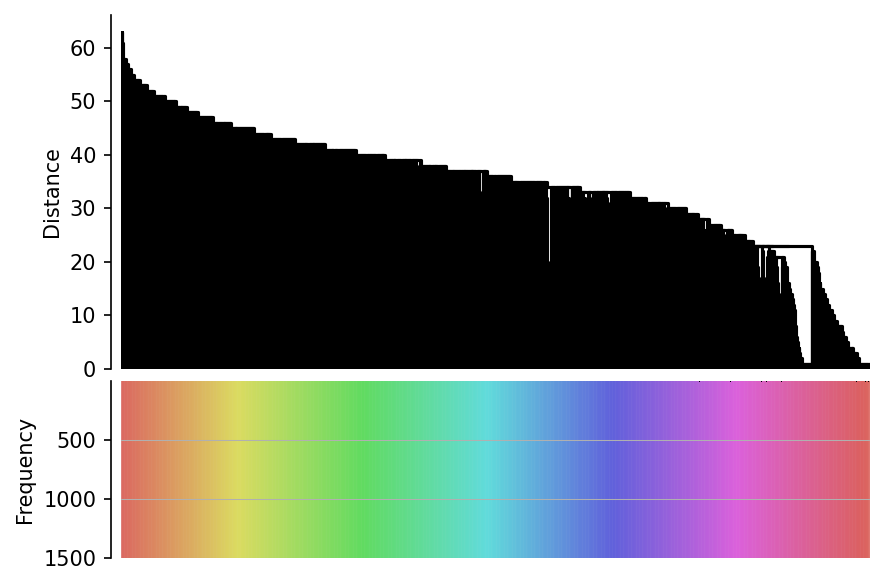

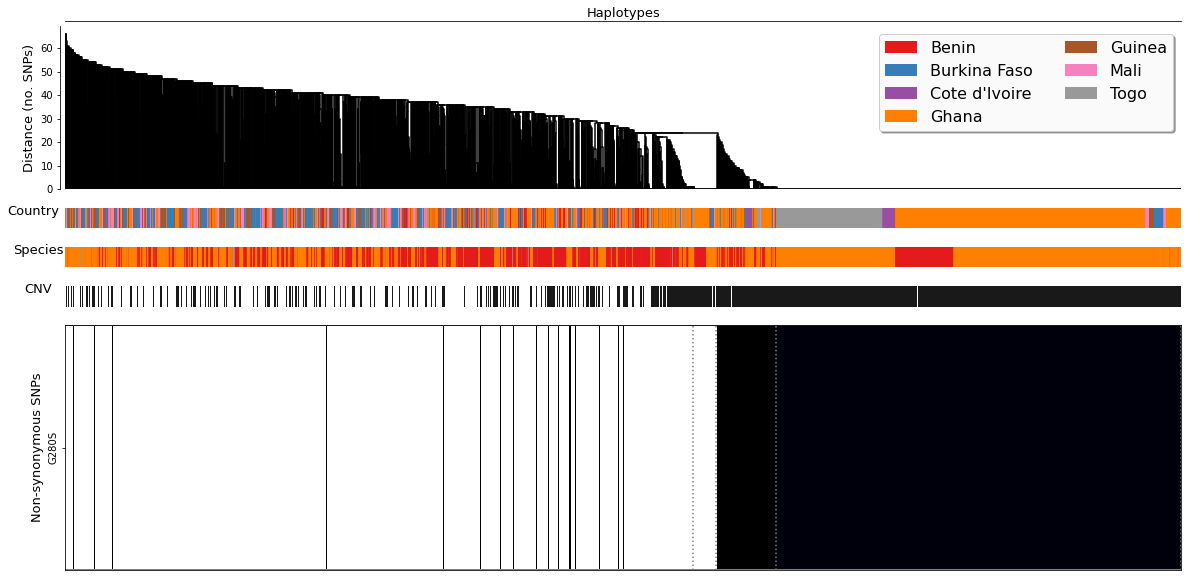

In [62]:
contig= '2R'
myregion = '2R:3450000-3500000'
transcript= "AGAP001356-RA"
gene = transcript.replace("-RA", "")

haploSelectionPlot(cohorts=cohorts, transcript=transcript, contig=contig)

['AG1000G-GH', 'AG1000G-ML-A', 'AG1000G-BF-A', 'AG1000G-BF-B', 'AG1000G-GN-A', 'AG1000G-GN-B', '1244-VO-GH-YAWSON-VMF00051', '1245-VO-CI-CONSTANT-VMF00054', '1253-VO-TG-DJOGBENOU-VMF00052', '1237-VO-BJ-DJOGBENOU-VMF00050'], query=None, cohort_size : 1643, nSNPs: 685
Remapping haplotype alleles to match snp effect data...
Clustering genotypes
Finding allele frequencies from cluster indices
There are 17 clusters with [190, 197, 68, 49, 54, 132, 154, 45, 70, 60, 69, 93, 53, 355, 325, 689, 683]
There are 16 amino acid changes with max_af > 0.05 & effect == 'NON_SYNONYMOUS_CODING'
Integrating CNV data...


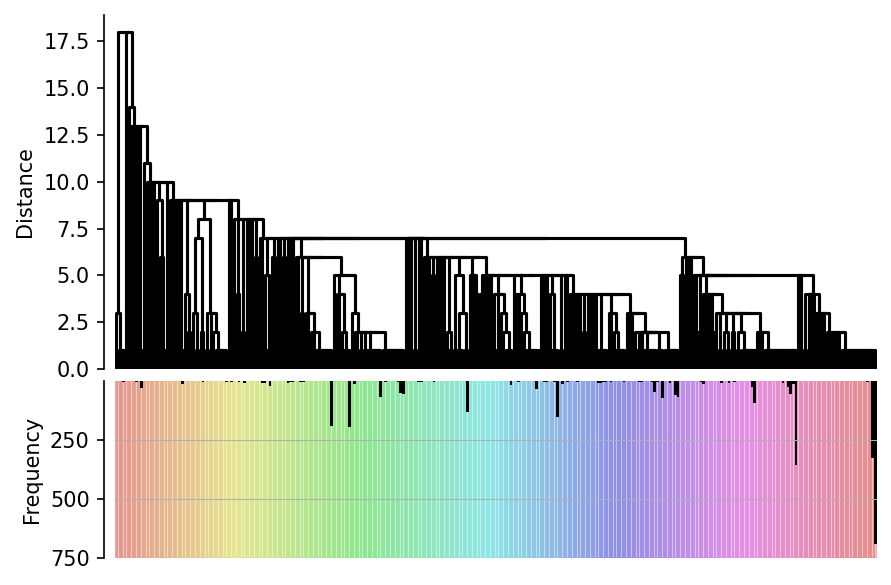

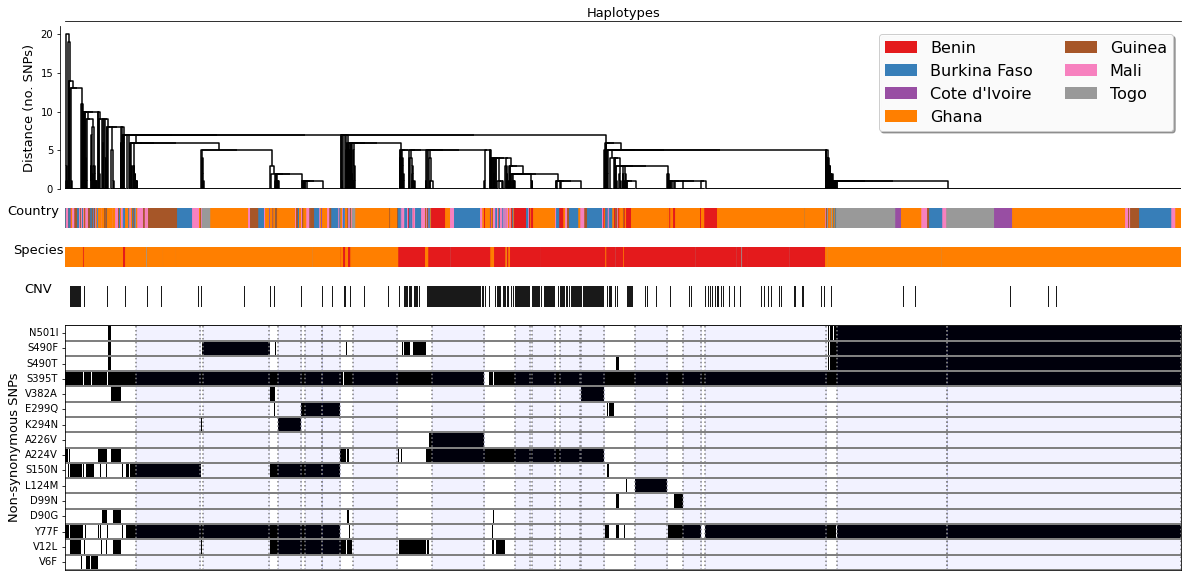

In [73]:
contig= '2R'
myregion = '2R:28470000-28510000'
transcript= "AGAP002862-RA"
gene = transcript.replace("-RA", "")

haploSelectionPlot(cohorts=cohorts, transcript=transcript, contig=contig)

['AG1000G-GH', 'AG1000G-ML-A', 'AG1000G-BF-A', 'AG1000G-BF-B', 'AG1000G-GN-A', 'AG1000G-GN-B', '1244-VO-GH-YAWSON-VMF00051', '1245-VO-CI-CONSTANT-VMF00054', '1253-VO-TG-DJOGBENOU-VMF00052', '1237-VO-BJ-DJOGBENOU-VMF00050'], query=None, cohort_size : 1643, nSNPs: 331
Remapping haplotype alleles to match snp effect data...
Clustering genotypes
Finding allele frequencies from cluster indices
There are 10 clusters with [56, 340, 76, 140, 339, 316, 341, 103, 822, 753]
There are 3 amino acid changes with max_af > 0.05 & effect == 'NON_SYNONYMOUS_CODING'
Integrating CNV data...


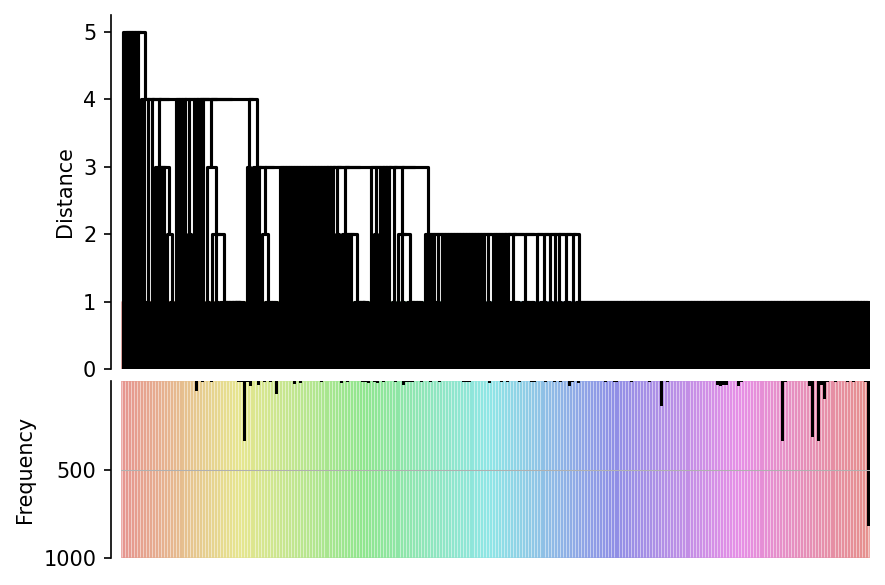

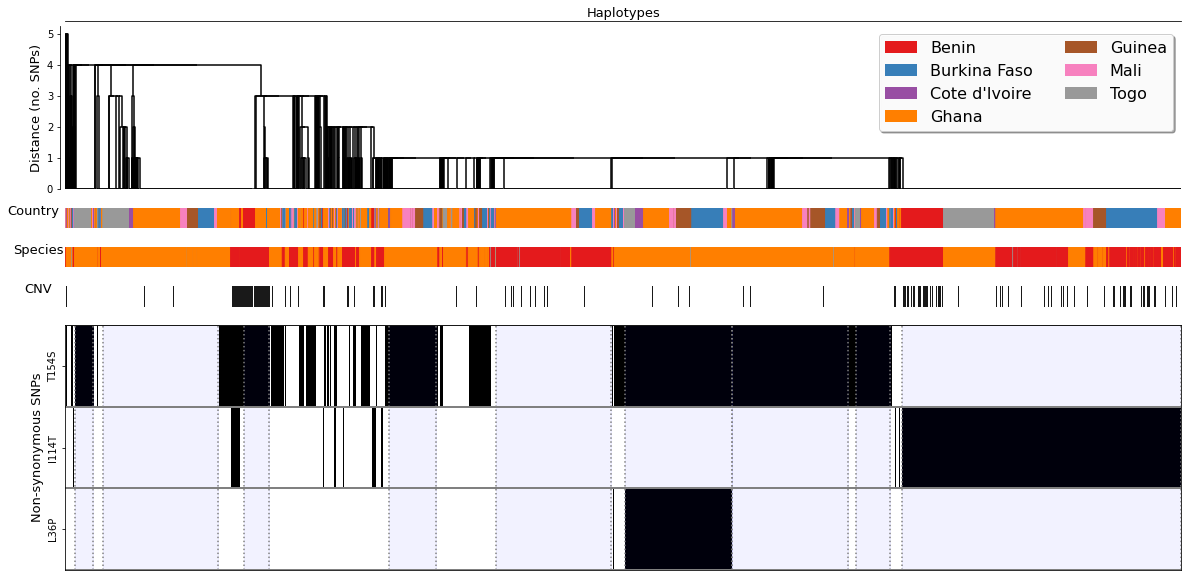

In [74]:
contig= '3R'
myregion = '3R:28595000-28600000'
transcript= "AGAP009194-RA"
gene = transcript.replace("-RA", "")

haploSelectionPlot(cohorts=cohorts, transcript=transcript, contig=contig)